# Spectral Products
Spectral products are created using mathematical combinations of specific bands (wavelength components). These spectral products can be useful for identifying spatial variations in vegetation, water or urbanization. This notebook covers the following spectral products:
Fractional Cover, NDBI, NDVI, NDWI, SAVI, EVI

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app='Spectral_Products')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import xarray as xr  

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

In [2]:
# Select a Product and Platform
product = "s2_google"
platform = "Sentinel-2A"

In [3]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# South Santo, Sanma - Main Island, Vanuatu
# Path of TS Harold, April 6, 2020
# latitude = (-15.682, -15.491) 
# longitude = (166.736, 166.904) 

# Efate Island, Vanuatu (near Port Vila)
# latitude = (-17.810, -17.691) 
# longitude = (168.247, 168.349) 

# South Pentacost - Vanuatu
# Path of TS Harold, April 7, 2020
# latitude = (-16.040, -15.778) 
# longitude = (168.158, 168.291) 

# West Majuro - Marshall Islands
# latitude = (7.132, 7.169) 
# longitude = (171.023, 171.048) 

# Kumasi, Ghana
# latitude = (6.529, 6.8734) 
# longitude = (-1.7954, -1.4211) 

# Tonga - Main Island
# latitude = (-21.29, -21.03) 
# longitude = (-175.37, -175.02) 

# Hornsby, AUS - High Frog Density
# latitude = (-33.8, -33.7) 
# longitude = (151.04, 151.16) 

# Niue Island
latitude = (-19.1743, -18.9264) 
longitude = (-169.9694, -169.7523) 

# Time Period (Year-Mon-Day)
time_extents = ('2021-03-01', '2021-06-01')


In [4]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Load the dataset and the required spectral bands or other parameters

In [5]:
sentinel_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          group_by='solar_day',
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'scl']) 

In [6]:
sentinel_dataset

<xarray.Dataset>
Dimensions:      (latitude: 2761, longitude: 2418, time: 19)
Coordinates:
  * time         (time) datetime64[ns] 2021-03-02T21:40:49.384000 ... 2021-05...
  * latitude     (latitude) float64 -18.93 -18.93 -18.93 ... -19.17 -19.17
  * longitude    (longitude) float64 -170.0 -170.0 -170.0 ... -169.8 -169.8
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 1270 1238 ... 10192 10224
    green        (time, latitude, longitude) int16 1412 1434 ... 10896 10888
    blue         (time, latitude, longitude) int16 1614 1504 ... 11544 11512
    nir          (time, latitude, longitude) int16 1250 1236 1238 ... 9528 9552
    swir1        (time, latitude, longitude) int16 932 932 919 ... 6313 6313
    swir2        (time, latitude, longitude) int16 899 899 872 ... 4370 4370
    scl          (time, latitude, longitude) int16 10 10 10 10 10 ... 9 9 9 9 9
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Mask out clouds and cloud shadows + water (if desired) and create a median mosaic

In [7]:
cloud_mask = (sentinel_dataset.scl != 0) & (sentinel_dataset.scl != 1) & \
             (sentinel_dataset.scl != 3) & (sentinel_dataset.scl != 8) & \
             (sentinel_dataset.scl != 9) & (sentinel_dataset.scl != 10)
land_mask =  ((sentinel_dataset.scl != 6) & cloud_mask)

# Land and Water Dataset = Land and Water pixels with NO Clouds and NO Cloud Shadows
land_and_water_dataset = sentinel_dataset.where(cloud_mask)

# Land Dataset = Land ONLY pixels with NO Clouds, NO Cloud Shadows and NO Water pixels
land_dataset = sentinel_dataset.where(land_mask)

from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_max_ndvi_mosaic, create_hdmedians_multiple_band_mosaic


In [8]:
# Select a compositing method to create your cloud-filtered mosaic
# Remove the comments from the pair of lines under one of the mosaic types
# Options are: Median or Max_NDVI 

# This is the MEDIAN mosaic
land_and_water_composite = create_median_mosaic(land_and_water_dataset, cloud_mask)
land_composite = create_median_mosaic(land_dataset, land_mask)
cloud_mask_composite = cloud_mask.max('time')

# This is the MAX_NDVI mosaic
# land_and_water_composite = create_max_ndvi_mosaic(land_and_water_dataset, cloud_mask)
# land_composite = create_max_ndvi_mosaic(land_dataset, land_mask)


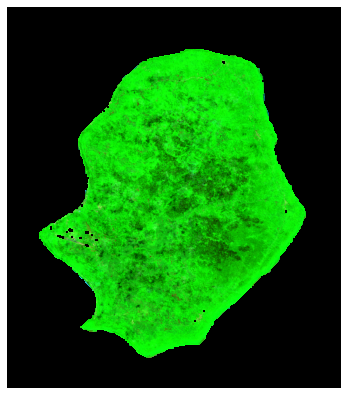

In [9]:
# Show the land-only composite (water will be removed ... black pixels)
from utils.data_cube_utilities.dc_rgb import rgb

# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Sentinel-2 Mosaic) = 742 = SWIR2, NIR, Green

rgb(land_composite, bands=['swir2', 'nir', 'green'], min_inten=0.0, max_inten=1.0, width=8)
plt.axis('off')
plt.show()

# Land Spectral Indices

In [10]:
def NDBI(dataset):
        return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [11]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [12]:
def NDWI(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

In [13]:
def SAVI(dataset):
        return (dataset.nir - dataset.red)/(dataset.nir + dataset.red + 0.5)*1.5

In [14]:
def EVI(dataset):
        return 2.5*(dataset.nir - dataset.red)/(dataset.nir + 6.0*dataset.red - 7.5*dataset.blue + 1.0)

In [15]:
# Water pixels masked (land only)
ndbi = NDBI(land_composite)  # Normalized Difference Build Up (Urbanization) Index
ndvi = NDVI(land_composite)  # Normalized Difference Vegetation Index
ndwi = NDWI(land_composite) # Normalized Difference Water Index

# Water pixels not masked
ndbi2 = NDBI(land_and_water_composite)  # Normalized Difference Build Up (Urbanization) Index
ndvi2 = NDVI(land_and_water_composite)  # Normalized Difference Vegetation Index
ndwi2 = NDWI(land_and_water_composite) # Normalized Difference Water Index

# Other Indices
savi = SAVI(land_composite)  # Soil Adjusted Vegetation Index 
evi = EVI(land_composite) # Enhanced Vegetation Index

In [16]:
ds_ndvi = ndvi2.to_dataset(name = "NDVI")
ds_ndwi = ndwi2.to_dataset(name=  "NDWI")
ds_ndbi = ndbi2.to_dataset(name = "NDBI")
normalization_dataset = ds_ndvi.merge(ds_ndwi).merge(ds_ndbi)

### Land Fractional Cover  

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. We use a model from CSIRO (Juan Gerschmann) and apply it to a median mosaic where: Bare Soil = bs, Photosynthetic Vegetation = pv, and Non-Photosynthetic Vegetation = npv. The product is a False Color RGB result where RGB = bs/pv/npv.

In [17]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(land_composite, clean_mask = 
                                      np.ones(land_composite.scl.shape).astype(np.bool)) 

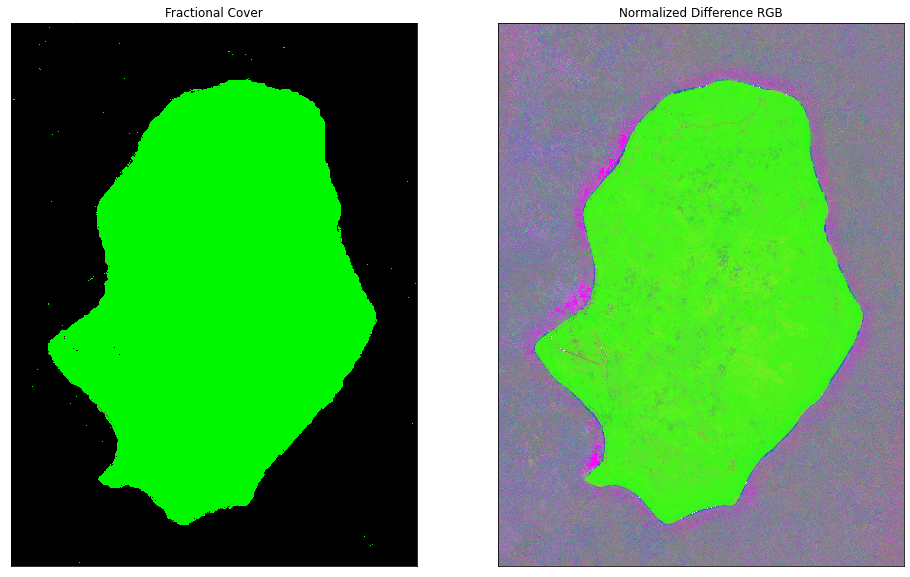

In [18]:
# Plot of Fractional Cover
# RED = Bare Soil or Urban Areas
# BLUE = Non-Green Vegetation
# GREEN = Green Vegetation
# BLACK = Water

# Plot of RGB = NDBI-NDVI-NDWI
# RED = Bare Soil or Urban Areas
# GREEN = Vegetation
# BLUE = Water

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

fc_rgb = frac_classes[['bs', 'pv', 'npv']].to_array()
ndi_rgb = normalization_dataset[['NDBI','NDVI','NDWI']].to_array()

(fc_rgb).plot.imshow(ax=ax[0], vmin=0.0, vmax=100.0)
(ndi_rgb).plot.imshow(ax=ax[1], vmin=-1.0, vmax=1.0)

ax[0].set_title('Fractional Cover'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Normalized Difference RGB'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

In [19]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


In [20]:
# Create a custom colour map for NDVI
# Water (blue) = NDVI -1.0 to 0.05
# Urban or Bare Soil (brown) = NDVI 0.05 to 0.25
# Low Vegetation (tan) = NDVI 0.25 to 0.4
# Croplands (light green) = NDVI 0.4 to 0.6
# Dense Vegetation / Forests (dark green) = NDVI 0.6 to 1.0

ndvi_cmap = mpl.colors.ListedColormap(['blue', '#a52a2a','#ffffcc' ,  '#2eb82e',  '#006600'])
ndvi_bounds = [-1, 0.05, 0.25,  0.4,  0.6, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

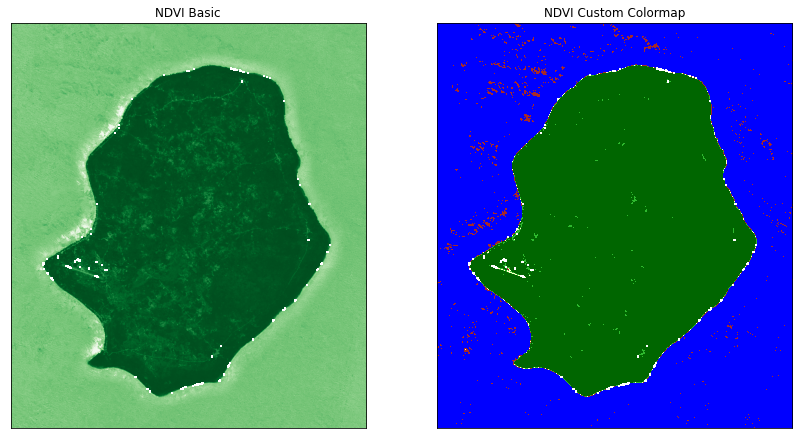

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].imshow(ndvi2, cmap="Greens", vmin=-1.0, vmax=1.0)
ax[1].imshow(ndvi2, cmap=ndvi_cmap, norm = ndvi_norm, vmin=-1.0, vmax=1.0)
ax[0].set_title('NDVI Basic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('NDVI Custom Colormap'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

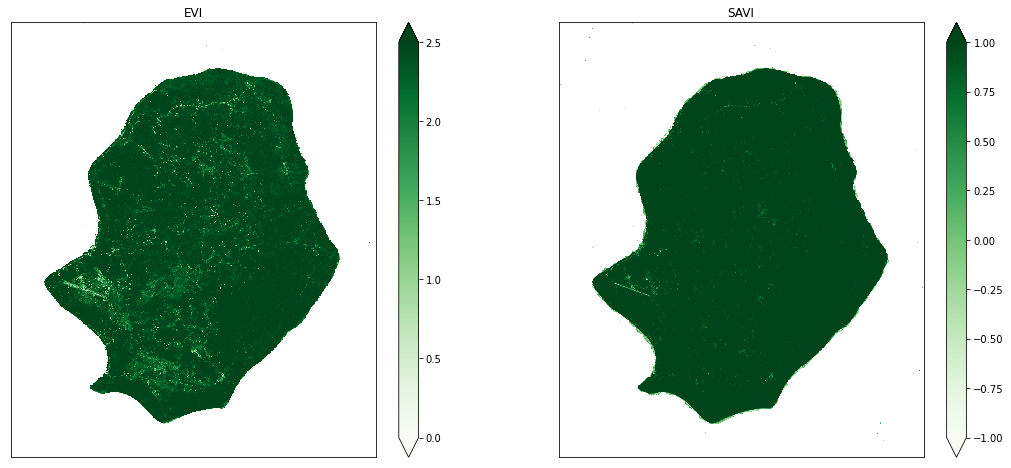

In [42]:
# EVI and SAVI indices using "land only" pixels
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
(evi).plot.imshow(ax=ax[0], cmap="Greens", vmin=0.0, vmax=2.5)
(savi).plot.imshow(ax=ax[1], cmap="Greens", vmin=-1.0, vmax=1.0)
ax[0].set_title('EVI'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('SAVI'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

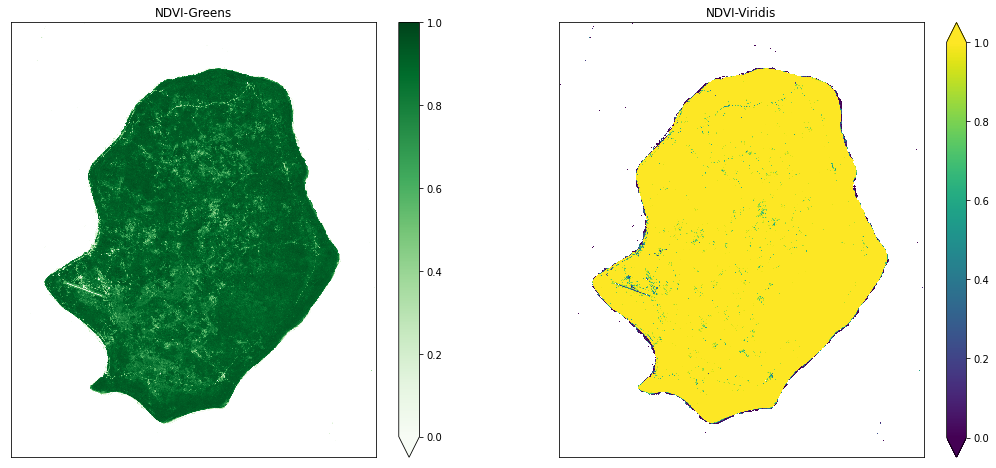

In [43]:
# OTHERS
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
(ndvi).plot.imshow(ax=ax[0], cmap="Greens", vmin=0.0, vmax=1.0)
(savi).plot.imshow(ax=ax[1], cmap="viridis", vmin=0.0, vmax=1.0)
ax[0].set_title('NDVI-Greens'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('NDVI-Viridis'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

## Create a threshold plot
First we will define a minimum threshold and a maximum threshold. Then you will create a plot that colors the region between the threshold a single color (e.g. red) and the region outside the threshold will be BLACK or WHITE. Also, we will calculate the % of pixels and the number of pixels in the threshold range.

In [23]:
from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.axis('off')
    plt.show()

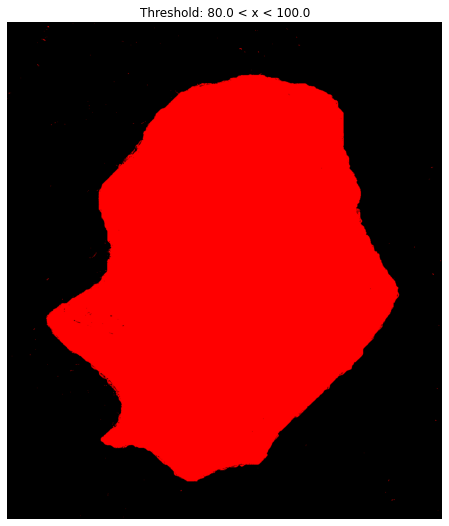

In [24]:
# Select a threshold range for your spectral variable and generate a plot
# Remove comments from the set of 3 lines for your desired variable
# Variable choices are NDBI, NDVI, EVI, FC-Bare Soil, FC-Photosynthetic Vegetation

# NDBI (Buildup Index) = -1.0 to 1.0 (full range)
# NDBI 0.0 to 0.2 is typical for urban areas
# -----------------------
# minimum_threshold = 0.0
# maximum_threshold = 0.3
# threshold_plot(ndbi, minimum_threshold, maximum_threshold, width = 8)

# NDVI (Vegetation Index) = -1.0 to 1.0
# NDVI < 0.0 = non-vegetation (bare soil)
# NDVI 0.2 to 0.6 = grasslands
# NDVI 0.6 to 0.9 = dense vegetation / trees
# -----------------------
# minimum_threshold = 0.05
# maximum_threshold = 0.25
# threshold_plot(ndvi, minimum_threshold, maximum_threshold, width = 8)

# EVI (Vegetation Index) = -1.0 to 2.5
# EVI 2.0 to 2.5 is typical for dense vegetation
# -----------------------
# minimum_threshold = 2.0
# maximum_threshold = 2.5
# threshold_plot(evi, minimum_threshold, maximum_threshold, width = 8)

# Fractional Cover (pv,npv,bs) = 0 to 100
# Bare Soil (bs) >40 = urbanization / bare soil
# ----------------------
# minimum_threshold = 20.0
# maximum_threshold = 100.0
# threshold_plot(frac_classes.bs, minimum_threshold, maximum_threshold, width = 8)

# Fractional Cover (pv,npv,bs) = 0 to 100
# Vegetation (pv) >80 = dense green vegetation
# ----------------------
minimum_threshold = 80.0
maximum_threshold = 100.0
threshold_plot(frac_classes.pv, minimum_threshold, maximum_threshold, width = 8)


In [25]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask.values)
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [26]:
# Select a threshold statistical function that matches your land spectral variable
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category
# ---------------------------------

# NDBI Threshold
# threshold_count(ndbi,minimum_threshold,maximum_threshold, cloud_mask_composite)
# threshold_percentage(ndbi,minimum_threshold,maximum_threshold)

# NDVI Threshold
# threshold_count(ndvi,minimum_threshold,maximum_threshold)
# threshold_percentage(ndvi,minimum_threshold,maximum_threshold)

# EVI Threshold
# threshold_count(evi,minimum_threshold,maximum_threshold)
# threshold_percentage(evi,minimum_threshold,maximum_threshold)

# Fractional Cover - Bare Soil
# threshold_count(frac_classes.bs, minimum_threshold, maximum_threshold)
# threshold_percentage(frac_classes.bs, minimum_threshold, maximum_threshold)

# Fractional Cover - Photosynthetic Vegetation
threshold_count(frac_classes.pv, minimum_threshold, maximum_threshold)
# threshold_percentage(frac_classes.pv, minimum_threshold, maximum_threshold)


{'total': 6676098,
 'total_non_cloudy': 6676098,
 'inside': 2816588,
 'outside': 3859510}

In [27]:
# threshold_percentage(ndbi,minimum_threshold,maximum_threshold)
threshold_percentage(frac_classes.pv, minimum_threshold, maximum_threshold)

{'percent_inside_threshold': 42.18913503067211,
 'percent_outside_threshold': 57.81086496932789,
 'percent_clouds': 0.0}

## GeoTIFF Output Products

In [28]:
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr

# Remove the comment to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 
# Change the desired bands at the end of the function

# Fractional Coverage
# write_geotiff_from_xr("geotiffs/frac_classes.tif", frac_classes, bands=['bs'])

# NDVI
# write_geotiff_from_xr("geotiffs/ndvi_land.tif", ndvi)

# EVI
# write_geotiff_from_xr("geotiffs/evi.tif", evi)

# WOFS
# write_geotiff_from_xr("geotiffs/wofs.tif", water_classification.wofs)

In [29]:
# !ls -lah geotiffs/*.tif